In [19]:
import lightgbm as lgb  # standard alias
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from scipy.stats import norm
from sklearn.model_selection import train_test_split
import math
from catboost import CatBoostRegressor
import catboost as cb
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance

# Define variables for model
train = pd.read_csv('feature_data/training_set_dropped.csv')

x_test = pd.read_csv('feature_data/testing_set_dropped.csv')
x_train = train.drop('revenue', axis=1)
y_train = train['revenue']

x_train, x_test, y_train, y_test = train_test_split(train.drop('revenue', axis=1), train['revenue'], random_state=104, train_size=0.8, shuffle=True)


# Save store ids, then remove this column
store_ids = x_test['store_id'].to_numpy()
ids = pd.DataFrame(store_ids)
ids.rename(columns={0 :'id'}, inplace=True )
# Drop store id
x_test = x_test.drop('store_id', axis=1)
x_train = x_train.drop('store_id', axis=1)




def save_submission(pred, name):
    predicted = pd.DataFrame(pred, columns = ['predicted'])
    output = pd.concat([ids,predicted],axis=1)
    output.to_csv(name, index=False)
    
def category(data):
    data['chain_name'] = data['chain_name'].astype('category')
    data['mall_name'] = data['mall_name'].astype('category')
    #data['lv1'] = data['lv1'].astype('category')
    data['lv2'] = data['lv2'].astype('category')
    data['lv3'] = data['lv3'].astype('category')
    data['lv4'] = data['lv4'].astype('category')
    return data
x_train = category(x_train)
x_test = category(x_test)

x_test.dtypes



chain_name                              category
mall_name                               category
lv2                                     category
lv3                                     category
lv4                                     category
total_nbr_people                         float64
nbr_people_per_store_in_grunnkrets       float64
busstops_within_1500m                      int64
busstops_within_3000m                      int64
busstops_within_6000m                      int64
num_stores_within_500m_and_same_lvl2       int64
num_stores_within_20km_and_same_lvl2       int64
closest_competitor_lv2                   float64
num_stores_within_20km_and_same_lvl3       int64
closest_competitor_lv3                   float64
mean_revenue_lv2                         float64
mean_revenue_lv3                         float64
median_revenue_lv2                       float64
median_revenue_lv3                       float64
mean_revenue_chain                       float64
median_revenue_lv4  

In [20]:
def catboost(x_train, y_train, x_test):
    model = CatBoostRegressor(iterations=1000,
                            learning_rate=0.01,
                            depth=12,
                            loss_function= 'RMSE')
    # Fit model
    model.fit(x_train, y_train)
    # Get predictions
    preds = model.predict(x_test)
    #preds = np.expm1(preds)
    save_submission(preds, "cat.csv")

In [21]:
def lgbm(x_train, x_test, y_train, y_test = None):
    #Hyper parameters
    hyper_params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': 'l2',
        'num_leaves': 31,
        'learning_rate': 0.05,
        "num_iterations": 3000,
        }
    categorical = ['chain_name', 'mall_name', 'lv3']

    #fit the model takes some time
    gbm = lgb.LGBMRegressor(**hyper_params)
    gbm.fit(x_train, y_train)
    print("fit")
    lgb.plot_importance(
        gbm
    )
    #predict
    y_pred = gbm.predict(x_test, num_iteration=gbm.best_iteration_)
    #y_pred = np.expm1(y_pred)
    save_submission(y_pred, "lgbm.csv")
    print(((y_pred - y_test) ** 2).mean() ** .5)

fit
0.7648611075269892


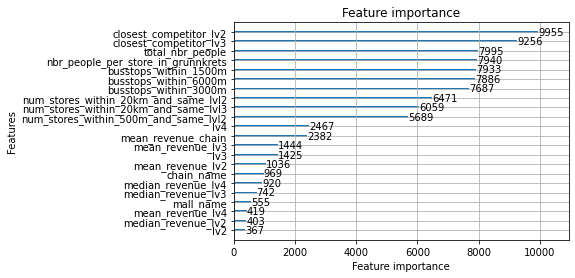

In [22]:
#catboost(x_test=x_test, y_train=y_train, x_train=x_train)
lgbm(x_train, x_test, y_train, y_test)